In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 1. Training

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.ticker import MaxNLocator

def plot_history(trainer):
    history = trainer.state.log_history
    
    train_steps = []
    train_losses = []
    
    val_epochs = []
    val_steps = []
    val_losses = []
    val_avg_r = []
    val_avg_mae = []

    for entry in history:
        # Training loss (logged by step)
        if 'loss' in entry and 'step' in entry:
            train_steps.append(entry['step'])
            train_losses.append(entry['loss'])
        
        # Validation metrics (logged by epoch)
        if 'eval_loss' in entry:
            current_epoch = entry.get('epoch', val_epochs[-1] + 1 if val_epochs else 1)
            val_epochs.append(current_epoch)
            val_steps.append(entry.get('step', 0)) 
            val_losses.append(entry['eval_loss'])
            
            if 'eval_avg_r' in entry: val_avg_r.append(entry['eval_avg_r'])
            if 'eval_avg_mae' in entry: val_avg_mae.append(entry['eval_avg_mae'])
            

    sns.set(style="whitegrid") 
    fig, axes = plt.subplots(1, 3, figsize=(22, 6)) 
    fig.suptitle('Model Analysis: Attention Pooling + Sparse MoE', fontsize=16, fontweight='bold', y=1.05)


    ax1 = axes[0]
    if train_steps:
        ax1.plot(train_steps, train_losses, label='Train Loss', color='lightblue', linewidth=1.5, alpha=0.9)
    if val_steps:
        ax1.plot(val_steps, val_losses, label='Val Loss', color='#E74C3C', linewidth=2, marker='o', markersize=6)
    
    ax1.set_title('Loss', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Steps', fontweight='bold')
    ax1.set_ylabel('Loss', fontweight='bold')
    ax1.legend(loc='upper right')
    ax1.grid(True, linestyle='--', alpha=0.7)

    ax2 = axes[1]
    if val_epochs and val_avg_r:
        ax2.plot(val_epochs, val_avg_r, label='Avg Pearson R', color='#2ECC71', linewidth=2.5, marker='s', markersize=7)
        ax2.set_title('Metric: Pearson R (Higher is better)', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Epoch', fontweight='bold')
        ax2.set_ylabel('R Score', fontweight='bold')
        ax2.legend(loc='lower right') 
        ax2.grid(True, linestyle='--', alpha=0.7)
        ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

    ax3 = axes[2]
    if val_epochs and val_avg_mae:
        ax3.plot(val_epochs, val_avg_mae, label='Avg MAE', color='#F39C12', linewidth=2.5, marker='*', markersize=8)
        ax3.set_title('Metric: MAE (Lower is better)', fontsize=14, fontweight='bold')
        ax3.set_xlabel('Epoch', fontweight='bold')
        ax3.set_ylabel('Error Value', fontweight='bold')
        ax3.legend(loc='upper right')
        ax3.grid(True, linestyle='--', alpha=0.7)
        ax3.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.tight_layout()
    save_path = "training_history_full_analysis.png"
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f">>> Save plot at: {save_path}")
    plt.show()

>>> [1] Loading & Processing Data...
>>> [2] Load Dataset and Tokenizer...
Data Loaded: 116 train samples | 21 test samples
>>> [3] Load Model...
>>> [4] Starting Training...


Epoch,Training Loss,Validation Loss,R V,Mae V,R A,Mae A,Avg R,Avg Mae
1,0.988600,0.957515,-0.031093,0.679225,0.169399,0.441994,0.069153,0.560609
2,1.010300,0.838119,-0.060653,0.993331,0.461416,0.488681,0.200382,0.741006
3,0.886900,0.874578,0.128392,0.699057,0.526278,0.637362,0.327335,0.668209
4,0.824300,0.816158,0.156074,0.695276,0.478194,0.447792,0.317134,0.571534
5,0.668800,0.930235,-0.055441,0.850014,0.347314,0.550259,0.145936,0.700136
6,0.507400,0.984183,-0.124757,0.894908,0.368046,0.485586,0.121644,0.690247


>>> [5] Saving BEST Model for Inference...
>>> Save plot at: training_history_full_analysis.png


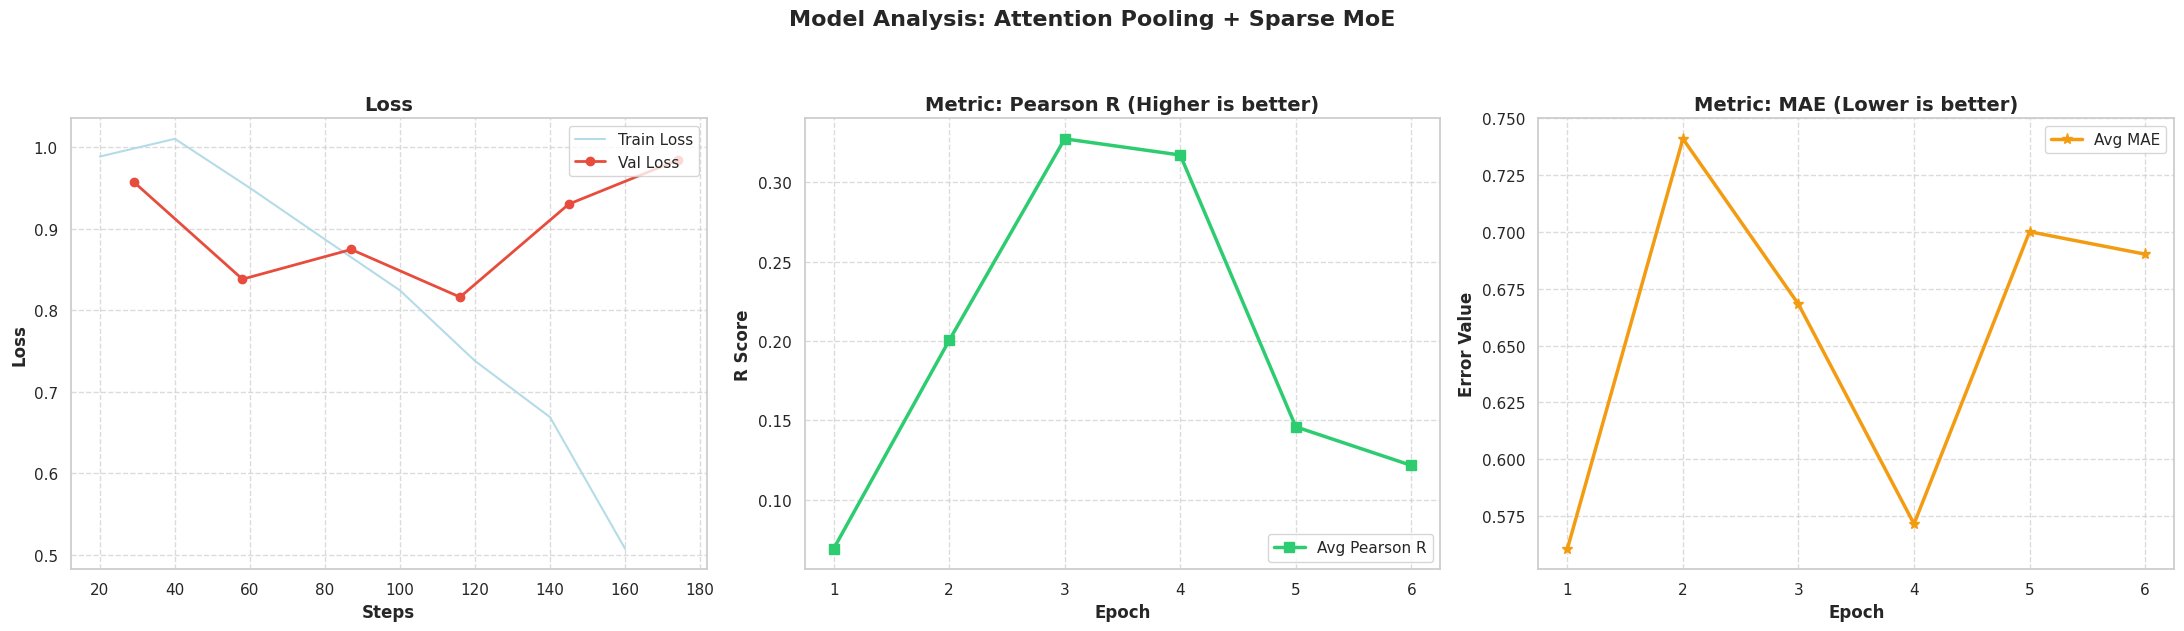

>>> [6] Evaluation on Test Set...


RESULTS SUBTASK 2B:
Avg Pearson R: 0.3273
  - Valence R: 0.1284
  - Arousal R: 0.5263
Avg MAE: 0.6682
  - mae Valence: 0.6991
  - mae Arousal: 0.6374
>>> Done! Download submission_model.zip


In [8]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer, AutoConfig, AutoModel,
    Trainer, TrainingArguments, EarlyStoppingCallback,
    set_seed,DataCollatorWithPadding
)
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler

import os
import re
import warnings
from typing import Dict, List
import warnings
warnings.filterwarnings('ignore')
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "disabled"
os.environ["TOKENIZERS_PARALLELISM"] = "false"
# ============================================================
# 1. CONFIGURATION
# ============================================================
class Config:
    model_name = {
        "roberta_sentiment": "cardiffnlp/twitter-roberta-base-sentiment-latest"
    }
    
    train_path = "/kaggle/input/semevaldataset/Dataset/train_subtask2b_detailed.csv"
    output_dir = "./semeval_subtask2b_model"
    
    max_seq_length = 512
    per_device_train_batch_size = 4
    gradient_accumulation_steps = 1
    
    num_train_epochs = 8
    learning_rate = 3e-5
    weight_decay = 0.1
    lr_scheduler_type = "cosine"
    warmup_ratio = 0.1
    logging_steps = 20
    seed = 3407
    max_grad_norm = 1.0
    
    fp16 = torch.cuda.is_available()
    bf16 = False 
    optim = "adamw_torch"
    seed = 3407 

set_seed(Config.seed)
# ============================================================
# 2. PREPARE DATA
# ============================================================

class EmotionDatasetSubtask2b(Dataset):
    def __init__(self, df, tokenizer):
        self.tokenizer = tokenizer
        self.data = []

        def clean_text(texts):
            return [re.sub(r"\s+", " ", str(t)).strip() for t in texts]

        for uid, user_df in df.groupby('user_id'):
            g1 = user_df[user_df['group'] == 1].sort_values('timestamp')
            g2 = user_df[user_df['group'] == 2].sort_values('timestamp')
            
            t1_list = clean_text(g1['text'].tail(5).tolist())
            t2_list = clean_text(g2['text'].tail(5).tolist())
            
            # Lưu riêng, KHÔNG nối vội
            text_g1 = " ".join(t1_list) if t1_list else ""
            text_g2 = " ".join(t2_list) if t2_list else ""
            
            # only get Past Features(V1, A1)
            row = user_df.iloc[0]
            num_feats = [row['mean_valence_half1'], row['mean_arousal_half1']]

            label = [
                row['disposition_change_valence'],
                row['disposition_change_arousal']
            ]

            self.data.append({
                'text_g1': text_g1,
                'text_g2': text_g2,
                'num_feats': num_feats,
                'labels': label
            })

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        
        # --- [SMART TRUNCATION] ---
        # 1. Tokenize riêng (add_special_tokens=False)
        tokens_g1 = self.tokenizer.encode(item['text_g1'], add_special_tokens=False)
        tokens_g2 = self.tokenizer.encode(item['text_g2'], add_special_tokens=False)
        
        half_len = (Config.max_seq_length - 3) // 2
        
        if len(tokens_g1) > half_len: tokens_g1 = tokens_g1[-half_len:]
        if len(tokens_g2) > half_len: tokens_g2 = tokens_g2[-half_len:]
            
        # 4. Concat: <s> G1 </s> </s> G2 </s>
        input_ids = (
            [self.tokenizer.cls_token_id] + 
            tokens_g1 + 
            [self.tokenizer.sep_token_id, self.tokenizer.sep_token_id] + 
            tokens_g2 + 
            [self.tokenizer.sep_token_id]
        )
        
        # 5. Padding
        attention_mask = [1] * len(input_ids)
        padding_len = Config.max_seq_length - len(input_ids)
        if padding_len > 0:
            input_ids += [self.tokenizer.pad_token_id] * padding_len
            attention_mask += [0] * padding_len
            
        return {
            'input_ids': torch.tensor(input_ids, dtype=torch.long),
            'attention_mask': torch.tensor(attention_mask, dtype=torch.long),
            'numerical_features': torch.tensor(item['num_feats'], dtype=torch.float), 
            'labels': torch.tensor(item['labels'], dtype=torch.float)
        }

# ============================================================
# 3. CUSTOM Model
# ============================================================

class BaseCCCLoss(nn.Module):
    """
    Lớp cơ sở tính toán CCC Loss.
    Công thức: Loss = 1 - CCC
    """
    def __init__(self, eps=1e-8):
        super().__init__()
        self.eps = eps

    def forward(self, y_pred, y_true):
        y_pred = y_pred.view(-1)
        y_true = y_true.view(-1)

        # Cal Mean và Variance
        mu_pred = torch.mean(y_pred)
        mu_true = torch.mean(y_true)

        var_pred = torch.var(y_pred, unbiased=False)
        var_true = torch.var(y_true, unbiased=False)

        std_pred = torch.std(y_pred, unbiased=False)
        std_true = torch.std(y_true, unbiased=False)

        # Cal Pearson Correlation (rho)
        # Covariance = Mean((x - mu_x)(y - mu_y))
        covariance = torch.mean((y_pred - mu_pred) * (y_true - mu_true))

        # CCC Loss(): (2 * cov) / (var_x + var_y + (mu_x - mu_y)^2)
        numerator = 2 * covariance
        denominator = var_pred + var_true + (mu_pred - mu_true)**2 + self.eps

        ccc = numerator / denominator
        return 1.0 - ccc

class CCCLoss(BaseCCCLoss):
    def __init__(self, eps=1e-8):
        super().__init__(eps)

class MeanPooling(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        return sum_embeddings / sum_mask

class Expert(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, output_dim)
        )
    def forward(self, x): return self.net(x)


class SparseMoELayer(nn.Module):
    """Sparse Mixture of Experts with Top-K Gating"""
    def __init__(self, input_dim, hidden_dim, output_dim, num_experts=4, top_k=2):
        super().__init__()
        self.num_experts, self.top_k = num_experts, top_k
        self.gate = nn.Linear(input_dim, num_experts)
        self.experts = nn.ModuleList([Expert(input_dim, hidden_dim, output_dim) for _ in range(num_experts)])
        
    def forward(self, x):
        # 1. Gating
        gate_logits = self.gate(x)
        gate_probs = F.softmax(gate_logits, dim=-1)
        
        # 2. Top-K Selection
        topk_weights, topk_indices = torch.topk(gate_probs, self.top_k, dim=-1)
        topk_weights = topk_weights / topk_weights.sum(dim=-1, keepdim=True) # Normalize
        
        # 3. Compute Experts
        # [Batch, Num_Experts, Output_Dim]
        all_expert_outputs = torch.stack([exp(x) for exp in self.experts], dim=1) 
        
        batch_size = x.size(0)
        output_dim = all_expert_outputs.size(-1)
        
        final_output = torch.zeros(batch_size, output_dim, device=x.device)
        
        for k in range(self.top_k):
            idx_k = topk_indices[:, k]
            
            weight_k = topk_weights[:, k].unsqueeze(1)

            idx_k_expanded = idx_k.view(-1, 1, 1).expand(-1, 1, output_dim)
            
            selected_expert_output = all_expert_outputs.gather(1, idx_k_expanded)
            
            final_output += weight_k * selected_expert_output.squeeze(1)
            
        return final_output


class Subtask2bModel(nn.Module):
    def __init__(self, model_name, num_experts=4, top_k=2):
        super().__init__()
        self.config = AutoConfig.from_pretrained(model_name)
        self.backbone = AutoModel.from_pretrained(model_name)
        
                
        hidden_size = self.config.hidden_size
        self.pooler = MeanPooling()

        #  FUSION DIM: Text(768) + Num(2) = 770
        fusion_dim = hidden_size + 2 

        # MoE Heads
        self.valence_head = SparseMoELayer(fusion_dim, 256, 1, num_experts, top_k)
        self.arousal_head = SparseMoELayer(fusion_dim, 256, 1, num_experts, top_k)

        self.loss_fct = CCCLoss()

    def forward(self, input_ids, attention_mask, numerical_features, labels=None):
        outputs = self.backbone(input_ids, attention_mask)
        text_emb = self.pooler(outputs.last_hidden_state, attention_mask)
        
        combined = torch.cat((text_emb, numerical_features), dim=1)

        val_pred = self.valence_head(combined) # [Batch, 1]
        aro_pred = self.arousal_head(combined) # [Batch, 1]
        
        logits = torch.cat((val_pred, aro_pred), dim=1)

        loss = None
        if labels is not None:
            l_v = self.loss_fct(val_pred.view(-1), labels[:, 0].view(-1))
            l_a = self.loss_fct(aro_pred.view(-1), labels[:, 1].view(-1))
            loss = 0.5* l_v + 0.5 * l_a
            
        return {"loss": loss, "logits": logits}

#===============
# METRICS
#===============

def compute_metrics_subtask2b(eval_pred):
    """Tính metrics chuẩn cho Subtask 2b"""
    predictions, labels = eval_pred
    if isinstance(predictions, tuple): predictions = predictions[0]

    pred_v = predictions[:, 0]
    pred_a = predictions[:, 1]
    lab_v = labels[:, 0]
    lab_a = labels[:, 1]

    def _pearson(x, y):
        if len(x) < 2: return 0.0
        if np.var(x) == 0 or np.var(y) == 0: return 0.0
        r, _ = pearsonr(x, y)
        return r

    def _mae(x, y):
        return np.mean(np.abs(x - y))

    r_v = _pearson(pred_v, lab_v)
    mae_v = _mae(pred_v, lab_v)
    r_a = _pearson(pred_a, lab_a)
    mae_a = _mae(pred_a, lab_a)

    avg_r = (r_v + r_a) / 2
    avg_mae = (mae_a + mae_v) / 2
    
    return {
        "r_v": r_v, "mae_v": mae_v,
        "r_a": r_a, "mae_a": mae_a,
        "avg_r": avg_r, "avg_mae" : avg_mae
    }

def train_model():
    print(">>> [1] Loading & Processing Data...")
    
    if not os.path.exists(Config.train_path):
        print(f"ERROR: File not found at {Config.train_path}")
        return

    # Load & Prepare Data
    df = pd.read_csv(Config.train_path)
    
    # Scale Data
    scaler = StandardScaler()
    cols = ['mean_valence_half1', 'mean_arousal_half1']
    df[cols] = scaler.fit_transform(df[cols])
    
    splitter = GroupShuffleSplit(n_splits=1, test_size=0.15, random_state=Config.seed)
    train_idx, test_idx = next(splitter.split(df, groups=df['user_id']))
    
    train_users = df.iloc[train_idx]['user_id'].unique()
    test_users = df.iloc[test_idx]['user_id'].unique()
    df_train = df[df['user_id'].isin(train_users)]
    df_test = df[df['user_id'].isin(test_users)]

    # Dataset & Tokenizer
    print(f">>> [2] Load Dataset and Tokenizer...")
    tokenizer = AutoTokenizer.from_pretrained(Config.model_name['roberta_sentiment'])
    train_ds = EmotionDatasetSubtask2b(df_train, tokenizer)
    test_ds = EmotionDatasetSubtask2b(df_test, tokenizer)
    print(f"Data Loaded: {len(train_ds)} train samples | {len(test_ds)} test samples")

    # Model & Trainer
    print(f">>> [3] Load Model...")
    model = Subtask2bModel(Config.model_name['roberta_sentiment']).to("cuda" if torch.cuda.is_available() else "cpu")

    # Args
    training_args = TrainingArguments(
        output_dir=Config.output_dir,
        learning_rate=Config.learning_rate,
        per_device_train_batch_size=Config.per_device_train_batch_size,
        per_device_eval_batch_size=Config.per_device_train_batch_size * 2,
        gradient_accumulation_steps=Config.gradient_accumulation_steps,

        num_train_epochs=Config.num_train_epochs,
        warmup_ratio=Config.warmup_ratio,

        # Speed Optimization
        group_by_length=True,
        dataloader_num_workers=2,

        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="avg_r",
        greater_is_better=True,

        fp16=Config.fp16,
        save_total_limit=1,
        remove_unused_columns=False, 

        report_to="none",
        logging_steps=Config.logging_steps,

        weight_decay=Config.weight_decay,
        lr_scheduler_type=Config.lr_scheduler_type,
        max_grad_norm=Config.max_grad_norm,
        optim=Config.optim,

        save_safetensors=True,
        seed=Config.seed
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_ds,
        eval_dataset=test_ds,
        tokenizer=tokenizer,
        data_collator=DataCollatorWithPadding(tokenizer),
        compute_metrics=compute_metrics_subtask2b,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
    )

    print(">>> [4] Starting Training...")
    trainer.train()

    # --- SAVING ARTIFACTS ---
    print(">>> [5] Saving BEST Model for Inference...")
    save_path = "./final_subtask2b_model"
    trainer.save_model(save_path)
    tokenizer.save_pretrained(save_path)
    
    model.config.save_pretrained(save_path)
    trainer.save_state()
    plot_history(trainer)

    print(">>> [6] Evaluation on Test Set...")
    eval_metrics = trainer.evaluate(test_ds)
    
    print("=" * 40)
    print(f"RESULTS SUBTASK 2B:")
    print(f"Avg Pearson R: {eval_metrics['eval_avg_r']:.4f}")
    print(f"  - Valence R: {eval_metrics['eval_r_v']:.4f}")
    print(f"  - Arousal R: {eval_metrics['eval_r_a']:.4f}")
    print(f"Avg MAE: {(eval_metrics['eval_mae_v'] + eval_metrics['eval_mae_a'])/2:.4f}")
    print(f"  - mae Valence: {eval_metrics['eval_mae_v']:.4f}")
    print(f"  - mae Arousal: {eval_metrics['eval_mae_a']:.4f}")
    print("=" * 40)
    
    # Zip to download
    import shutil
    shutil.make_archive("submission_model", 'zip', save_path)
    print(">>> Done! Download submission_model.zip")

if __name__ == "__main__":
    train_model()

# 2. Inference

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoConfig, AutoModel
from sklearn.preprocessing import StandardScaler
import os
import re
import warnings

warnings.filterwarnings('ignore')

# ====================================================
# 1. CONFIG
# ====================================================
class InferenceConfig:

    base_model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"
    

    model_path = "./final_subtask2b_model" 
    

    train_csv_path = "/kaggle/input/semevaldataset/Dataset/train_subtask2b_detailed.csv"
    
    test_csv_path = "/kaggle/input/semevaldataset/Dataset/TEST_RELEASE_5JAN2026/subtask2b_forecasting_user_marker.csv"
    
    output_file = "submission.csv"
    max_seq_length = 512
    batch_size = 16
    device = "cuda" if torch.cuda.is_available() else "cpu"

# ====================================================
# 2. HELPER: DATA PROCESSING
# ====================================================
def calculate_user_features(df):
    print("-> Calculating features from raw data...")
    g1_df = df[df['group'] == 1]
    

    user_feats = g1_df.groupby('user_id')[['valence', 'arousal']].mean()
    user_feats.columns = ['mean_valence_half1', 'mean_arousal_half1']
    

    all_users = df['user_id'].unique()
    user_feats = user_feats.reindex(all_users).fillna(0.0)
    return user_feats

def clean_text(texts):
    return [re.sub(r"\s+", " ", str(t)).strip() for t in texts]

# ====================================================
# 3. MODEL ARCHITECTURE 
# ====================================================

class BaseCCCLoss(nn.Module):
    def __init__(self, eps=1e-8):
        super().__init__()
        self.eps = eps
    def forward(self, y_pred, y_true):
        return 0.0

class CCCLoss(BaseCCCLoss):
    def __init__(self, eps=1e-8): super().__init__(eps)

# --- Lớp 2: Pooling ---
class MeanPooling(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        return sum_embeddings / sum_mask

# --- Lớp 3: Expert ---
class Expert(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, output_dim)
        )
    def forward(self, x): return self.net(x)

# --- Lớp 4: Sparse MoE Layer ---
class SparseMoELayer(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_experts=4, top_k=2):
        super().__init__()
        self.num_experts, self.top_k = num_experts, top_k
        self.gate = nn.Linear(input_dim, num_experts)
        self.experts = nn.ModuleList([Expert(input_dim, hidden_dim, output_dim) for _ in range(num_experts)])
        
    def forward(self, x):
        # 1. Gating
        gate_logits = self.gate(x)
        gate_probs = F.softmax(gate_logits, dim=-1)
        
        # 2. Top-K Selection
        topk_weights, topk_indices = torch.topk(gate_probs, self.top_k, dim=-1)
        topk_weights = topk_weights / topk_weights.sum(dim=-1, keepdim=True)
        
        # 3. Compute Experts
        all_expert_outputs = torch.stack([exp(x) for exp in self.experts], dim=1) 
        
        # 4. Weighted Sum
        batch_size = x.size(0)
        output_dim = all_expert_outputs.size(-1)
        final_output = torch.zeros(batch_size, output_dim, device=x.device)
        
        for k in range(self.top_k):
            idx_k = topk_indices[:, k]
            weight_k = topk_weights[:, k].unsqueeze(1)
            
            idx_k_expanded = idx_k.view(-1, 1, 1).expand(-1, 1, output_dim)
            selected_expert_output = all_expert_outputs.gather(1, idx_k_expanded)
            
            # [QUAN TRỌNG] squeeze(1) để fix lỗi dimension
            final_output += weight_k * selected_expert_output.squeeze(1)
            
        return final_output

# --- Lớp 5: Model ---
class Subtask2bModel(nn.Module):
    def __init__(self, model_name, num_experts=4, top_k=2):
        super().__init__()
        self.config = AutoConfig.from_pretrained(model_name)
        self.backbone = AutoModel.from_pretrained(model_name)
        
        hidden_size = self.config.hidden_size
        self.pooler = MeanPooling()

        # Fusion: Text(768) + Num(2) = 770
        fusion_dim = hidden_size + 2 

        self.valence_head = SparseMoELayer(fusion_dim, 256, 1, num_experts, top_k)
        self.arousal_head = SparseMoELayer(fusion_dim, 256, 1, num_experts, top_k)

        self.loss_fct = CCCLoss()

    def forward(self, input_ids, attention_mask, numerical_features):
        outputs = self.backbone(input_ids, attention_mask)
        text_emb = self.pooler(outputs.last_hidden_state, attention_mask)
        combined = torch.cat((text_emb, numerical_features), dim=1)

        val_pred = self.valence_head(combined)
        aro_pred = self.arousal_head(combined)
        
        return torch.cat((val_pred, aro_pred), dim=1)

# ====================================================
# 4. INFERENCE DATASET
# ====================================================
class InferenceDataset(Dataset):
    def __init__(self, df, tokenizer, user_feature_map):
        self.tokenizer = tokenizer
        self.data = []
        self.user_ids = []

        for uid, user_df in df.groupby('user_id'):
            self.user_ids.append(uid)
            g1 = user_df[user_df['group'] == 1].sort_values('timestamp')
            g2 = user_df[user_df['group'] == 2].sort_values('timestamp')
            
            t1_list = clean_text(g1['text'].tail(5).tolist())
            t2_list = clean_text(g2['text'].tail(5).tolist())
            
            text_g1 = " ".join(t1_list) if t1_list else ""
            text_g2 = " ".join(t2_list) if t2_list else ""
            
            # Lấy feature số từ map (đã scale)
            num_feats = user_feature_map.get(uid, [0.0, 0.0])

            self.data.append({
                'text_g1': text_g1, 'text_g2': text_g2, 'num_feats': num_feats
            })

    def __len__(self): return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        tokens_g1 = self.tokenizer.encode(item['text_g1'], add_special_tokens=False)
        tokens_g2 = self.tokenizer.encode(item['text_g2'], add_special_tokens=False)
        
        # Smart Truncation: (512 - 3) // 2
        half_len = (InferenceConfig.max_seq_length - 3) // 2
        if len(tokens_g1) > half_len: tokens_g1 = tokens_g1[-half_len:]
        if len(tokens_g2) > half_len: tokens_g2 = tokens_g2[-half_len:]
            
        input_ids = ([self.tokenizer.cls_token_id] + tokens_g1 + 
                     [self.tokenizer.sep_token_id, self.tokenizer.sep_token_id] + 
                     tokens_g2 + [self.tokenizer.sep_token_id])
        
        attention_mask = [1] * len(input_ids)
        padding_len = InferenceConfig.max_seq_length - len(input_ids)
        if padding_len > 0:
            input_ids += [self.tokenizer.pad_token_id] * padding_len
            attention_mask += [0] * padding_len
            
        return {
            'input_ids': torch.tensor(input_ids, dtype=torch.long),
            'attention_mask': torch.tensor(attention_mask, dtype=torch.long),
            'numerical_features': torch.tensor(item['num_feats'], dtype=torch.float)
        }

# ====================================================
# 5. MAIN FUNCTION
# ====================================================
def run_inference():
    print(">>> [1] Setting up Scaler...")
    scaler = StandardScaler()
    
    if os.path.exists(InferenceConfig.train_csv_path):
        df_train = pd.read_csv(InferenceConfig.train_csv_path)
        if 'mean_valence_half1' in df_train.columns:
             train_feats = df_train[['mean_valence_half1', 'mean_arousal_half1']]
        else:
             train_feats = calculate_user_features(df_train)
        
        # Fill NaN with 0
        train_feats = train_feats.fillna(0.0)
        scaler.fit(train_feats)
        print("Scaler fitted on Training Data.")
    else:
        print("Warning: Train file not found. Scaler might be inaccurate.")

    # 2. Load Test Data
    print(f">>> [2] Loading Test Data: {InferenceConfig.test_csv_path}")
    if not os.path.exists(InferenceConfig.test_csv_path):
        print("Error: Test file not found!"); return

    df_test_raw = pd.read_csv(InferenceConfig.test_csv_path)
    
    if 'is_forecasting_user' in df_test_raw.columns:
        forecasting_users = df_test_raw[df_test_raw['is_forecasting_user'] == True]['user_id'].unique()
        print(f" Found {len(forecasting_users)} forecasting users.")
    else:
        forecasting_users = df_test_raw['user_id'].unique()
        print("is_forecasting_user' column not found. Will output ALL users.")

    # Tính feature cho Test & Scale
    test_feats = calculate_user_features(df_test_raw)
    scaled_feats = scaler.transform(test_feats)
    user_feat_map = {uid: scaled_feats[i] for i, uid in enumerate(test_feats.index)}

    # 3. Init Model & Loader
    print(">>> [3] Loading Model & Tokenizer...")
    tokenizer = AutoTokenizer.from_pretrained(InferenceConfig.base_model_name)
    # Khởi tạo model với config mặc định (num_experts=4, top_k=2 khớp với training)
    model = Subtask2bModel(InferenceConfig.base_model_name)
    
    # Load Weights
    weights_path = f"{InferenceConfig.model_path}/pytorch_model.bin"
    if not os.path.exists(weights_path):
        weights_path = f"{InferenceConfig.model_path}/model.safetensors"
        if os.path.exists(weights_path):
            from safetensors.torch import load_file
            state_dict = load_file(weights_path)
        else:
            print(f" Error: Weights not found in {InferenceConfig.model_path}"); return
    else:
        state_dict = torch.load(weights_path, map_location=InferenceConfig.device)
        
    model.load_state_dict(state_dict)
    model.to(InferenceConfig.device)
    model.eval()

    test_ds = InferenceDataset(df_test_raw, tokenizer, user_feat_map)
    test_loader = DataLoader(test_ds, batch_size=InferenceConfig.batch_size, shuffle=False)

    # 4. Predict
    print(">>> [4] Running Prediction...")
    all_preds = []
    
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(InferenceConfig.device)
            attention_mask = batch['attention_mask'].to(InferenceConfig.device)
            num_feats = batch['numerical_features'].to(InferenceConfig.device)
            
            # Output là tensor [Batch, 2]
            outputs = model(input_ids, attention_mask, num_feats)
            all_preds.append(outputs.cpu().numpy())
            
    all_preds = np.concatenate(all_preds, axis=0)
    
    # 5. Filter & Save
    print(">>> [5] Saving Submission...")
    full_submission = pd.DataFrame({
        'user_id': test_ds.user_ids,
        'pred_dispo_change_valence': all_preds[:, 0],
        'pred_dispo_change_arousal': all_preds[:, 1]
    })
    
    # Lọc chỉ lấy forecasting users
    final_submission = full_submission[full_submission['user_id'].isin(forecasting_users)]
    
    final_submission.to_csv(InferenceConfig.output_file, index=False)
    print(f"Saved to {InferenceConfig.output_file}")
    print(f"Total rows: {len(final_submission)}")
    print(final_submission.head())

if __name__ == "__main__":
    run_inference()

>>> [1] Setting up Scaler...
Scaler fitted on Training Data.
>>> [2] Loading Test Data: /kaggle/input/semevaldataset/Dataset/TEST_RELEASE_5JAN2026/subtask2b_forecasting_user_marker.csv
 Found 46 forecasting users.
-> Calculating features from raw data...
>>> [3] Loading Model & Tokenizer...
>>> [4] Running Prediction...
>>> [5] Saving Submission...
Saved to submission.csv
Total rows: 46
    user_id  pred_dispo_change_valence  pred_dispo_change_arousal
4         6                  -1.154336                  -0.301361
6         8                   1.071032                   0.930562
8        11                   1.237316                   0.991912
11       16                  -1.045296                   0.038493
16       21                   0.876069                   0.549227
